# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [3]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_04_20.csv')

In [4]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


In [5]:
# Check size of the data set
raw_df.shape

(2008, 4)

In [6]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [7]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [8]:
raw_df.dropna()
raw_df.shape

(2008, 4)

In [9]:
raw_df.head()

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0


## Data Cleaning

In [10]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   286
Loan Default                  252
Debt Yield Fall                95
Loan default                   75
Mezzanine Default              39
Tenant Failure                 35
Debt yield fall                34
Bankruptcy                     29
DSCR Fall                      18
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Aggregate Debt Yield Fall      11
Mezzanine Outstanding          10
Mezzanine default               8
Aggregate debt yield fall       6
Debt Yield Falll                4
Aggregate DSCR Fall             2
Aggregate debt yield            1
Name: Trigger, dtype: int64

In [11]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [12]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  327
Unspecified                   286
Debt Yield Fall               129
Mezzanine Default              47
Tenant Failure                 35
Bankruptcy                     29
Dscr Fall                      18
Aggregate Debt Yield Fall      17
Operator Termination           17
Renovations                    16
Sponsor Termination            14
Mezzanine Outstanding          10
Debt Yield Falll                4
Aggregate Dscr Fall             2
Aggregate Debt Yield            1
Name: Trigger, dtype: int64

In [13]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [14]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [15]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [16]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [17]:
raw_df.shape

(2008, 3)

In [18]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

22 unique documents have been included in the data set


In [19]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     82
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     75
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     75
20170525_02DFUI_Prospectus_SD000000002352389122.pdf     68
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [20]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have trigger counts that range from {min_triggers} to {max_triggers}.')

The 22 Documents have trigger counts that range from 25 to 176.


In [21]:
# Check for duplicate rows
raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
raw_df['is_duplicate'].value_counts()

False    1937
True       71
Name: is_duplicate, dtype: int64

In [22]:
num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
print(f'There are {num_duplicated_rows} row duplicates in the data set.')

There are 71 row duplicates in the data set.


In [23]:
# We'll remove the extra duplicate rows
raw_df = raw_df.drop('is_duplicate', axis = 1)
raw_df = raw_df.drop_duplicates()

In [24]:
raw_df.shape

(1937, 3)

In [25]:
raw_df.head()

,Document,Sentence,Trigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate Dscr Fall
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default


In [26]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1030
Loan Default                  317
Unspecified                   277
Debt Yield Fall               119
Mezzanine Default              43
Tenant Failure                 35
Bankruptcy                     26
Aggregate Debt Yield Fall      18
Dscr Fall                      17
Renovations                    16
Operator Termination           15
Sponsor Termination            14
Mezzanine Outstanding           8
Aggregate Dscr Fall             2
Name: Trigger, dtype: int64

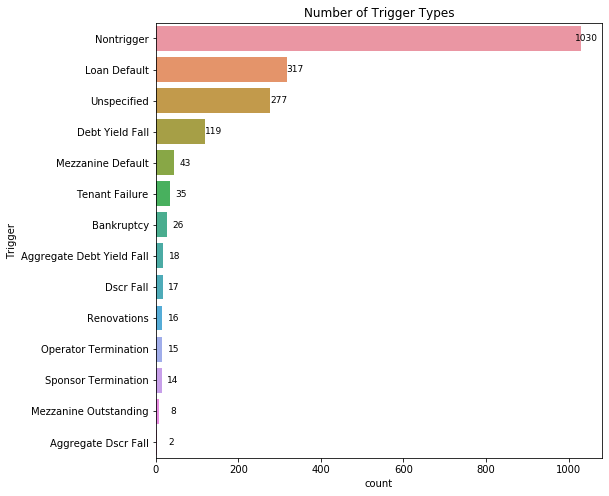

In [27]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [28]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf    176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf    133
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf    130
20160510_02B0XU_Prospectus_SD000000002312723382.pdf    117
20190131_02IFCW_Prospectus_SD000000002578232050.pdf    114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf    112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf    111
20190108_02IFF1_Prospectus_SD000000002570458466.pdf    109
20190208_02IM7M_Prospectus_SD000000002581684036.pdf    109
20190205_02IJ77_Prospectus_SD000000002579874729.pdf     99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf     84
20170814_02E227_Prospectus_SD000000002367167139.pdf     77
20180125_02FE6L_Prospectus_SD000000002394837596.pdf     71
20170727_02DTVX_Prospectus_SD000000002362015714.pdf     69
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf     67
20170801_02DX5C_Prospectus_SD000000002363000910.pdf     64
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf     

In [29]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [30]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [31]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [32]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Export reshaped to CSV file
# df.to_csv('../data/reshaped_06_02_20.csv')

In [34]:
df.dtypes

Document                     object
Sentence                     object
loan_default                  Int64
aggregate_dscr_fall           Int64
dscr_fall                     Int64
unspecified                   Int64
debt_yield_fall               Int64
aggregate_debt_yield_fall     Int64
mezzanine_default             Int64
tenant_failure                Int64
mezzanine_outstanding         Int64
operator_termination          Int64
bankruptcy                    Int64
sponsor_termination           Int64
renovations                   Int64
nontrigger                    Int64
dtype: object

In [35]:
df.shape

(1760, 16)

In [36]:
# We can confirm that the number of Triggers is consistent with the prior dataframe
df.sum()

Document                     20120828_01Y0R8_Prospectus_CM00000000205875087...
Sentence                     On each Business Day, the financial institutio...
loan_default                                                               317
aggregate_dscr_fall                                                          2
dscr_fall                                                                   17
unspecified                                                                277
debt_yield_fall                                                            119
aggregate_debt_yield_fall                                                   18
mezzanine_default                                                           43
tenant_failure                                                              35
mezzanine_outstanding                                                        8
operator_termination                                                        15
bankruptcy                                          

## Feature Engineering

In [37]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [38]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235


## Natural Language Processing of the sentence column

In [39]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [40]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

['During',
 'a',
 'Trigger',
 'Period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'Mortgage',
 'Loan',
 'is',
 'continuing',
 ',',
 'all',
 'amounts',
 'available',
 'in',
 'the',
 'Cash',
 'Management',
 'Account',
 'will',
 'be',
 'applied',
 'on',
 'each',
 'Loan',
 'Payment',
 'Date',
 'in',
 'the',
 'following',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'Tax',
 'and',
 'Insurance',
 'Reserve',
 'Account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'taxes',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'projected',
 'annual',
 'insurance',
 'premiums',
 '(',
 'unless',
 'certain',
 'blanket',
 'policies',
 'are',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'scheduled',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'Mortgage',
 'Loan',
 'and',
 'all',
 'other',
 'amounts',
 'then',
 'due',
 'and',
 'payab

In [41]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

['during',
 'a',
 'trigger',
 'period',
 'or',
 'while',
 'an',
 'event',
 'of',
 'default',
 'under',
 'the',
 'mortgage',
 'loan',
 'be',
 'continue',
 ',',
 'all',
 'amount',
 'available',
 'in',
 'the',
 'cash',
 'management',
 'account',
 'will',
 'be',
 'apply',
 'on',
 'each',
 'loan',
 'payment',
 'date',
 'in',
 'the',
 'follow',
 'order',
 'of',
 'priority',
 ':',
 '(',
 'i',
 ')',
 'to',
 'the',
 'tax',
 'and',
 'insurance',
 'reserve',
 'account',
 ',',
 '(',
 'a',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'tax',
 'and',
 '(',
 'b',
 ')',
 '1/12th',
 'of',
 'project',
 'annual',
 'insurance',
 'premium',
 '(',
 'unless',
 'certain',
 'blanket',
 'policy',
 'be',
 'in',
 'effect',
 ')',
 ',',
 '(',
 'ii',
 ')',
 'to',
 'the',
 'lender',
 ',',
 'the',
 'amount',
 'of',
 'all',
 'schedule',
 'or',
 'delinquent',
 'interest',
 'and',
 'principal',
 'on',
 'the',
 'mortgage',
 'loan',
 'and',
 'all',
 'other',
 'amount',
 'then',
 'due',
 'and',
 'payable',
 'under',
 'the

In [42]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [43]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [44]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti..."
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...


In [45]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

'On each Business Day , the financial institution maintaining the blocked ac'

In [46]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

'on each business day , the financial institution maintain the block account'

In [47]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [48]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

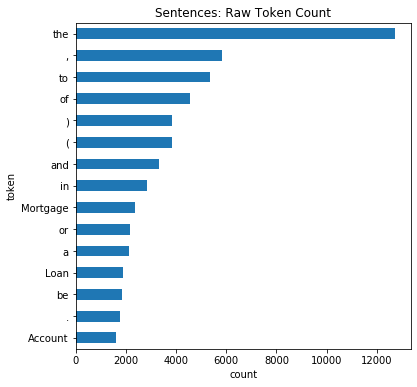

In [49]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

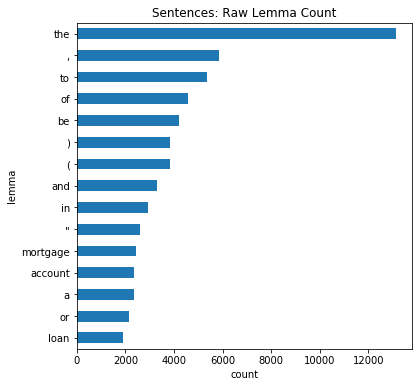

In [50]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [51]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [52]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

['on',
 'each',
 'business',
 'day',
 'the',
 'financial',
 'institution',
 'maintain',
 'the',
 'block']

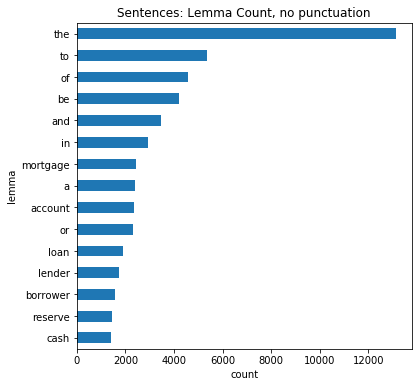

In [53]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [54]:
df['SentenceLemmas_nopunc'].head()

0    on each business day   the financial instituti...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

In [55]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [56]:
df['SentenceLemmas_nopunc'].head()

0    on each business day the financial institution...
1    the borrower have establish and be require to ...
2    during a trigger period or while an event of d...
3    on any business day all amount on deposit in t...
4    available fund in each cash management account...
Name: SentenceLemmas_nopunc, dtype: object

## Preprocessing and Preparation for Modeling

In [57]:
short_stopwords = ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']

In [58]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['hundred',
 'thence',
 'fifty',
 'done',
 'least',
 'much',
 'being',
 'sixty',
 'that',
 'nothing',
 'further',
 'have',
 'ten',
 'get',
 'should',
 'side',
 'forty',
 'where',
 'move',
 'otherwise',
 'thereafter',
 'various',
 'nobody',
 'seems',
 'most',
 'themselves',
 'although',
 'hers',
 'why',
 'yours',
 'these',
 'nowhere',
 'via',
 'four',
 'us',
 'behind',
 'without',
 'become',
 'a',
 'wherein',
 'their',
 'again',
 'when',
 'may',
 'if',
 'among',
 'whence',
 'all',
 'not',
 'someone',
 'else',
 'of',
 'toward',
 'the',
 'anything',
 'both',
 'ever',
 'fifteen',
 'first',
 'once',
 'part',
 'several',
 'either',
 'besides',
 'anyhow',
 'could',
 'front',
 'eight',
 'give',
 'no',
 'same',
 'third',
 'though',
 'still',
 'cannot',
 'six',
 'twelve',
 'which',
 'afterwards',
 'amount',
 'between',
 'whose',
 'also',
 'nine',
 'it',
 'up',
 'did',
 'how',
 'my',
 'onto',
 'call',
 'your',
 'then',
 'around',
 'those',
 'am',
 'whether',
 'before',
 'along',
 'hereafter',
 'i

In [59]:
# Choose to exclude anything with numbers are might be particularly relevant
to_exclude = ['thereupon', 'cannot', 'should'] 

In [60]:
# Define our selected stopword lists 
select_stopwords = [word for word in stopwords if word not in to_exclude]
select_stopwords

['hundred',
 'thence',
 'fifty',
 'done',
 'least',
 'much',
 'being',
 'sixty',
 'that',
 'nothing',
 'further',
 'have',
 'ten',
 'get',
 'side',
 'forty',
 'where',
 'move',
 'otherwise',
 'thereafter',
 'various',
 'nobody',
 'seems',
 'most',
 'themselves',
 'although',
 'hers',
 'why',
 'yours',
 'these',
 'nowhere',
 'via',
 'four',
 'us',
 'behind',
 'without',
 'become',
 'a',
 'wherein',
 'their',
 'again',
 'when',
 'may',
 'if',
 'among',
 'whence',
 'all',
 'not',
 'someone',
 'else',
 'of',
 'toward',
 'the',
 'anything',
 'both',
 'ever',
 'fifteen',
 'first',
 'once',
 'part',
 'several',
 'either',
 'besides',
 'anyhow',
 'could',
 'front',
 'eight',
 'give',
 'no',
 'same',
 'third',
 'though',
 'still',
 'six',
 'twelve',
 'which',
 'afterwards',
 'amount',
 'between',
 'whose',
 'also',
 'nine',
 'it',
 'up',
 'did',
 'how',
 'my',
 'onto',
 'call',
 'your',
 'then',
 'around',
 'those',
 'am',
 'whether',
 'before',
 'along',
 'hereafter',
 'in',
 'almost',
 'twent

## Train/Test Split

In [61]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sentence_char_count,SentenceTokens,SentenceLemmas,SentenceLemmas_nopunc
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,446,"On each Business Day , the financial instituti...","on each business day , the financial instituti...",on each business day the financial institution...
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,837,The Borrower has established and is required t...,the borrower have establish and be require to ...,the borrower have establish and be require to ...
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1772,During a Trigger Period or while an event of d...,during a trigger period or while an event of d...,during a trigger period or while an event of d...
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,302,On any Business Day all amounts on deposit in ...,on any business day all amount on deposit in t...,on any business day all amount on deposit in t...
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,235,Available funds in each Cash Management Accoun...,available fund in each cash management account...,available fund in each cash management account...


In [62]:
# Start by predicting Loan Default trigger

target = 'loan_default'


X = df['Sentence']
y = df['debt_yield_fall']

y = y.astype('int')

In [63]:
y.dtypes

dtype('int64')

In [64]:
# Checking shape of X and y 
print(f'X shape is {X.shape}')
print(f'y shape is {y.shape}')

X shape is (1760,)
y shape is (1760,)


In [65]:
y.value_counts()

0    1641
1     119
Name: debt_yield_fall, dtype: int64

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1320,) (1320,)
(440,) (440,)


In [67]:
X.head()

0    On each Business Day, the financial institutio...
1    The Borrower has established and is required t...
2    During a Trigger Period or while an event of d...
3    On any Business Day all amounts on deposit in ...
4    Available funds in each Cash Management Accoun...
Name: Sentence, dtype: object

In [68]:
X_train.shape[0]

1320

In [69]:
y_train.shape[0]

1320

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [70]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
#    'cvec__min_df': [2],
#    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 530.588


In [71]:
#log_reg = LogisticRegression()
#logreg.fit(X_train, y_train)


In [72]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.999
Test score is 0.989
Cross Validation score is 0.974
Seconds elapsed for score calculation: 2.020


In [73]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.992
Best Parameters :{'cvec__max_features': 400, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


### 2: TFIDF + Logistic Regression GridSearch and modeling

In [74]:
# Define TFIDF + Logistic Regression Pipeline

pipe_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter = 4000, random_state = RANDOM_STATE))])

tfidf_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],  
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = tfidf_params, cv = 3, scoring = 'accuracy')

results_tfidf = gs_tfidf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 534.201


In [75]:
t0 = time.time()
print(f'Training score is {results_tfidf.score(X_train, y_train):.3f}')
print(f'Test score is {results_tfidf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_tfidf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.989
Test score is 0.968
Cross Validation score is 0.966
Seconds elapsed for score calculation: 3.161


In [76]:
print(f'Best Score: {results_tfidf.best_score_}')
print(f'Best Parameters: {results_tfidf.best_params_}')

Best Score: 0.9787878787878789
Best Parameters: {'tfidf__max_features': 600, 'tfidf__ngram_range': (1, 4), 'tfidf__stop_words': None}


### 3: CountVectorizer + Multinomial Naive Bayes GridSearch & modeling

In [77]:
# Define CountVectorizer + Multinomial Naive Bayes Grisearch pipeline

pipe_mnb = Pipeline([('cvec', CountVectorizer()), ('mnb', MultinomialNB())])
mnb_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'cvec__stop_words': [None, short_stopwords, select_stopwords],
    'cvec__max_features': [100, 200, 400, 600, 800, 1000],
#    'cvec__min_df': [3],
#    'cvec__max_df': [ .99],
    }

gs_mnb = GridSearchCV(pipe_mnb, param_grid = mnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_mnb = gs_mnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 533.390


In [78]:
t0 = time.time()
print(f'Training score is {results_mnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_mnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_mnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.958
Test score is 0.932
Cross Validation score is 0.891
Seconds elapsed for score calculation: 8.035


In [79]:
print(f'Best Score: {results_mnb.best_score_}')
print(f'Best Parameters: {results_mnb.best_params_}')

Best Score: 0.9621212121212123
Best Parameters: {'cvec__max_features': 1000, 'cvec__ngram_range': (1, 10), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


### 4: TFIDF + Gaussian Naive Bayes GridSearch & modeling

In [80]:
# Define TFIDF + Gaussian Naive Bayes Gridsearch pipeline

from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


pipe_gnb = Pipeline([('tfidf', TfidfVectorizer()), ('to_dense', DenseTransformer()),('gnb', GaussianNB())])

gnb_params = {
    'tfidf__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9), (1,10)],
    'tfidf__stop_words': [None, short_stopwords, select_stopwords],
    'tfidf__max_features': [100, 200, 400, 600, 800, 1000],
#    'tfidf__min_df': [2],
#    'tfidf__max_df': [.99],
    }

gs_gnb = GridSearchCV(pipe_gnb, param_grid = gnb_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_gnb = gs_gnb.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

Seconds elapsed for fitting: 470.833


In [81]:
t0 = time.time()
print(f'Training score is {results_gnb.score(X_train, y_train):.3f}')
print(f'Test score is {results_gnb.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_gnb.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 0.970
Test score is 0.966
Cross Validation score is 0.934
Seconds elapsed for score calculation: 1.365


In [82]:
print(f'Best Score: {results_gnb.best_score_}')
print(f'Best Parameters: {results_gnb.best_params_}')

Best Score: 0.9590909090909091
Best Parameters: {'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['the', 'and', 'a', 'to', 'I', 'it', 'be', 'for', 'with', 'that']}


## Model Selection
- In this section we compare the Train and Test scores across the various models

In [83]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')

Baseline Score:                                0.930
CountVectorizer + LogisticRegression Accuracy: 0.999
TfidfVectorizer + LogisticRegression Accuracy: 0.989
CountVectorizer + Multinomial Naive Bayes:     0.958
TfidfVectorizer + Gaussian Naive Bayes:        0.970


In [84]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')

Baseline Score:                                0.930
CountVectorizer + LogisticRegression Accuracy: 0.989
TfidfVectorizer + LogisticRegression Accuracy: 0.968
CountVectorizer + Multinomial Naive Bayes:     0.932
TfidfVectorizer + Gaussian Naive Bayes:        0.966


## Model Evaluation

In [85]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [86]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.2482510704651455,
 0.24566919051524763,
 -0.02142188010620918,
 -0.058902004280836806,
 -0.024702975244591727,
 -0.024702975244591727,
 -0.2571019996989004,
 0.020657090240965778,
 -0.1465184564479217,
 -0.2075252830038229]

In [87]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [88]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [89]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
219,low,0.965990
398,yield,0.857412
90,debt yield,0.857412
221,low cash flow,0.765245
66,cash flow period,0.765245
142,flow period,0.765245
220,low cash,0.765245
88,debt,0.646212
310,purpose,0.516853
369,than,0.501559


In [90]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
147,from,-0.779117
231,means,-0.735134
169,in,-0.601515
14,all,-0.597596
389,will,-0.546469
215,lockbox,-0.506815
330,reserve,-0.495864
203,lender,-0.472385
268,on,-0.452548
335,respect,-0.401268


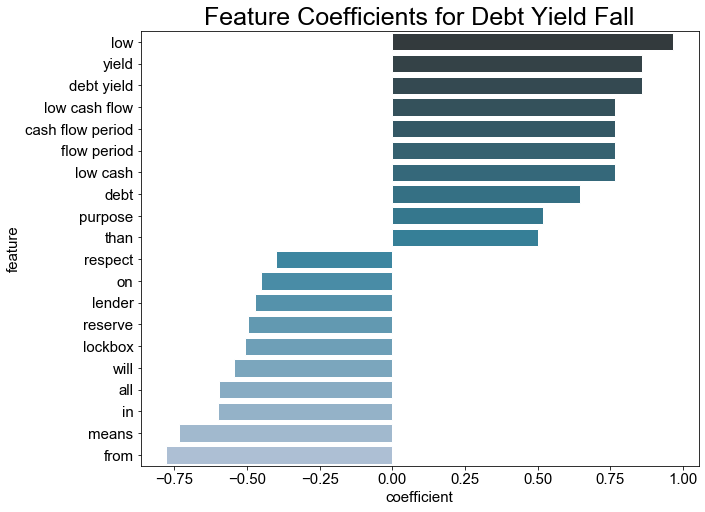

In [91]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for Debt Yield Fall', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

### Calculating predictions and Confusion Matrix

In [92]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [93]:
# Checking our predictions
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [94]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[407   2]
 [  3  28]]


In [95]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [96]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,407,2
Actual Positive,3,28


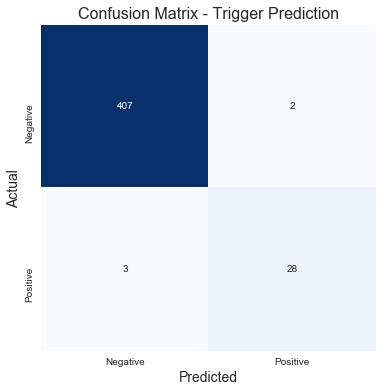

In [97]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [98]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

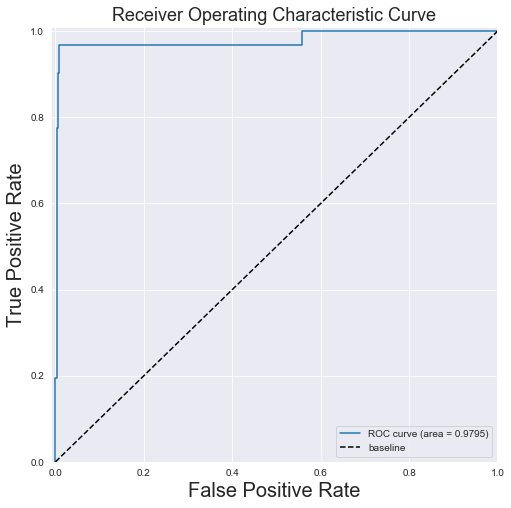

In [99]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [100]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [101]:
result_cols = ['prediction', 'actual', 'Sentence']
results = pd.DataFrame({'prediction': list(preds), 'actual': list(y_test), 'Sentence': list(X_test)})


In [102]:
misclassified = results[results['prediction'] != results['actual']]


In [103]:
misclassified.head(10)

,prediction,actual,Sentence
75,0,1,"The Borrowers are permitted to avoid the commencement or terminate the continuance of a Trigger Period by either (i) making a prepayment or defeasance of the Mortgage Loan in accordance with the terms of the Loan Agreement in an amount that when subtracted from the principal balance of the Mortgage Loan then outstanding for purposes of calculating debt yield would result in a debt yield (as calculated under the Loan Agreement) that equals or exceeds 6.25% (provided that in the event of such prepayment or defeasance, the Trigger Period will cease promptly upon prepayment or defeasance of such amount that is adequate to satisfy 6.25%), together with all of the other amounts required pursuant to “—Voluntary Prepayment” below, or (ii) delivering to the lender, as additional Collateral, a letter of credit in an amount that when subtracted from the principal balance of the Mortgage Loan then outstanding for purposes of calculating debt yield would result in a debt yield (as calculated under the Loan Agreement) that equals or exceeds 6.25% (provided that the aggregate notional amount of all outstanding letters of credit delivered under the Loan Agreement at no time may exceed 10% of the principal balance of the Mortgage Loan then outstanding)."
154,0,1,"“Debt Yield Trigger Level” means (i) prior to the date which is twelve (12) months after the completion of the Required Renovation Work in accordance with the Completion Guaranty (but in no event longer than thirty (30) months from the commencement of the Required Renovation Work), 6.50%, and (ii) thereafter, 7.00%."
188,0,1,"“Debt Yield Trigger Level” means (i) prior to the date which is twelve (12) months after the completion of the Required Renovation Work in accordance with the Completion Guaranty (but in no event longer than thirty (30) months from the commencement of the Required Renovation Work), 6.50%, and (ii) thereafter, 7.00%."
251,1,0,"If the requirements of clauses (a) through (f) above are satisfied by Borrower, Borrower will not be subject to Trigger Period as a result of the Aggregate Debt Yield falling below the Minimum Debt Yield until such time as the “Guaranteed Amount” (as defined in the Partial Payment Guaranty) if applied to the outstanding principal balance of the Mortgage Loan, would not be sufficient to prevent the occurrence of a Trigger Period as a result of the Aggregate Debt Yield falling below the Minimum Debt Yield."
257,1,0,"“Trigger Period” means a period: (A) commencing upon the earliest of: (i) the occurrence and continuance of a Mortgage Loan Event of Default; (ii) the receipt by Mortgage Lender of written notice from any Mezzanine Lenders that a Mezzanine Loan Default (other than as the result of the occurrence of a Mortgage Loan Event of Default) has occurred; or (iii) the Aggregate Debt Yield falling below the Minimum Debt Yield; and (B) expiring upon: (x) with regard to any Trigger Period commenced in connection with clause (A)(i) above, the curing of such Mortgage Loan Event of Default; (y) with regard to any Trigger Period commenced in connection with clause (A)(ii) above, the applicable Mezzanine Lenders has delivered to Mortgage Lender written notice that such Mezzanine Loan Default has been cured or waived (and no other Mezzanine Loan Default is then continuing); and (z) with regard to any Trigger Period commenced in connection with clause (A)(iii) above, the date that the Aggregate Debt Yield is equal to or greater than the Minimum Debt Yield for two (2) consecutive calendar quarters."
